In [1]:
import numpy as np
import matplotlib.pyplot as plt

Some utility functions for plotting.

In [2]:
def plot_data(X):
    plt.scatter(X[:, 0], X[:, 1], color='b')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 7)
    plt.ylim(0, 7)

def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:

    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)
    
def plot_ev(mu, eig_vec_1, eig_vec_2):

    arrow_1_end = mu+eig_vec_1
    arrow_1_x = [mu[0], arrow_1_end[0]]
    arrow_1_y = [mu[1], arrow_1_end[1]]

    arrow_2_end = mu+eig_vec_2
    arrow_2_x =  [mu[0], arrow_2_end[0]]
    arrow_2_y =  [mu[1], arrow_2_end[1]]

    plt.plot(mu[0], mu[1], 'xr')
    plt.plot((mu+eig_vec_1)[0], (mu+eig_vec_1)[1], 'xr')
    plt.plot(arrow_1_x, arrow_1_y, 'red')
    plt.plot(arrow_2_x, arrow_2_y, 'red')
    
def plot_sum_eig_val_ratio(eig_vals):

    plt.figure('Eig Val sum Ratio')
    plt.grid()
    sorted_eig_vals = np.sort(eig_vals, axis=0)[::-1]
    all_eig_val_sum = np.sum(sorted_eig_vals)
    partially_sum = np.cumsum(sorted_eig_vals, axis=0)
    ratios = partially_sum/all_eig_val_sum
    plt.plot(np.arange(1, sorted_eig_vals.shape[0] + 1, 1), ratios)
    plt.xlabel('number principle components')
    plt.ylabel('ratio $\lambda$')
    return ratios

## Toy Example 

We will apply PCA on the following 2d-toy example.

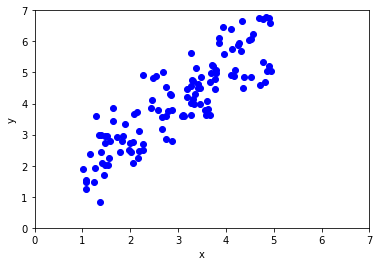

In [3]:
np.random.seed(0)

x = np.random.uniform(1,5, size=(120, 1))
y = x + 1 + np.random.normal(0, 0.7, size=x.shape)

X = np.concatenate((x, y), axis = 1)
plot_data(X)

In [4]:
def do_pca(X, n_principle_comps):

    # get mean of the data
    mu_x = np.mean(X, axis=0)

    # subtract mean from data
    zero_mean_X = X-mu_x

    # compute covariance
    cvar_X = np.cov(zero_mean_X.T)

    v, U = np.linalg.eig(cvar_X)

    # sort eigenvalues
    sorted_v_idx = np.argsort(v)[::-1] # sort descending order

    # Principle components
    U_p = U[:, sorted_v_idx]
    v_p = v[sorted_v_idx]

    # v_p: eigenvalues sorted in decreasing order
    # U_p: eigenvectors columns sorted according to eigenvalues in decreasing order
    # mu_x: mean of data
    # cvar_X: covariance of data
    # v: unsorted eigenvalues
    # U: unsorted eigenvectors
    return v_p[:n_principle_comps], U_p[:, :n_principle_comps], mu_x, cvar_X, v, U

def transform_low_dim(X, U_p, mu_x):

    # subtract the mean of the data
    zero_mean_X = X-mu_x
    
    # transform the data to low dimensional space
    z = np.dot(zero_mean_X, U_p)
    if len(z.shape)==1:
        z = z.reshape((-1, 1))
    return z

def transform_back(z, U_p, mu_x):

    if len(z.shape)==1:
        z = z.reshape((-1, 1))
    if len(U_p.shape)==1:
        U_p = U_p.reshape((-1, 1))
    # transform the data back to high-dimensional space
    return np.dot(z, U_p.T) + mu_x

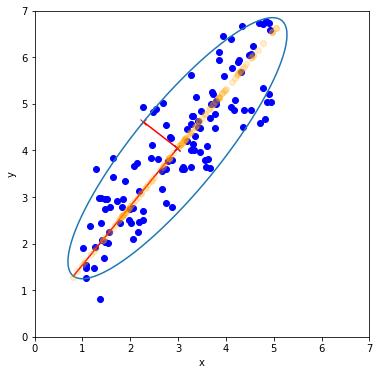

In [8]:
plt.figure(figsize=(6,6))

plot_data(X)

# do the principle component analysis
v_p, U_p, mu_X, cvar_X, v, U = do_pca(X, n_principle_comps=1)

plot_ev(mu_X, 2*np.sqrt(v[0])*U[:, 0], 2*np.sqrt(v[1])*U[:, 1])

draw_2d_gaussian(mu_X, cvar_X)

z = transform_low_dim(X, U_p, mu_X)

z_retr = transform_back(z, U_p, mu_X)

plt.plot(z_retr[:, 0], z_retr[:, 1], 'o', color='orange', alpha=0.2)

## Hand-written digit data-set

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()          # data is 8x8 image with 1797 images
targets = digits.target        # the target class [0, 1, .... 9]

# get the images for digit 3 only
digits_3_indx = np.where(targets == 3)[0]
digit_3_data = digits.data[digits_3_indx]       # shape: (183, 64)  -> (8 x 8)
digit_3_targets = digits.target[digits_3_indx]       # only needed to verify that we load digit 3

<Figure size 432x288 with 0 Axes>

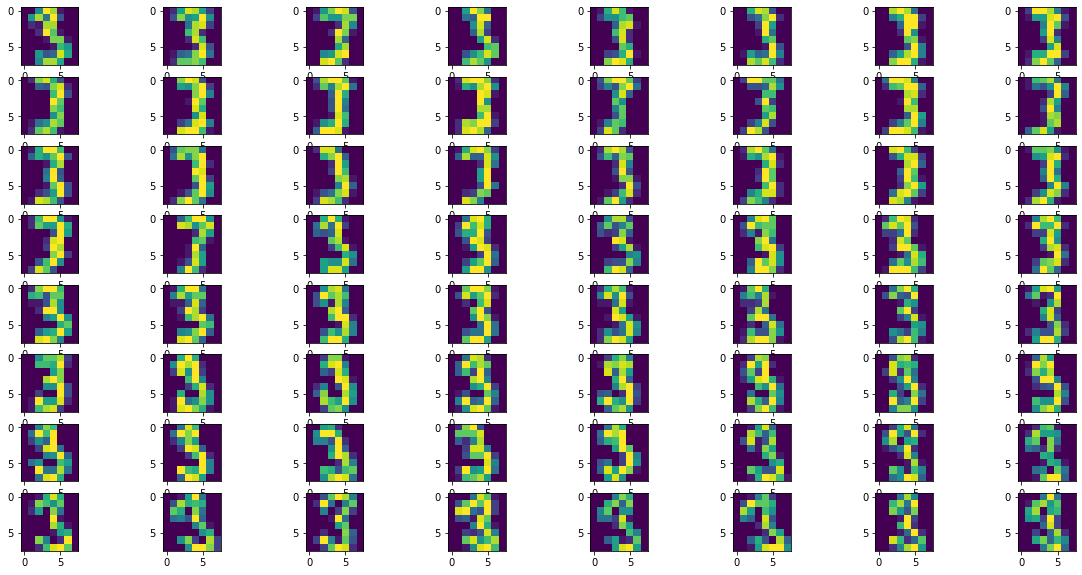

In [10]:
# Plot the original digit 3 images
plt.figure()
fig, axes = plt.subplots(8, 8, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(digit_3_data[i].reshape(8, 8))#, cmap='binary')

Text(0.5, 1.0, 'original')

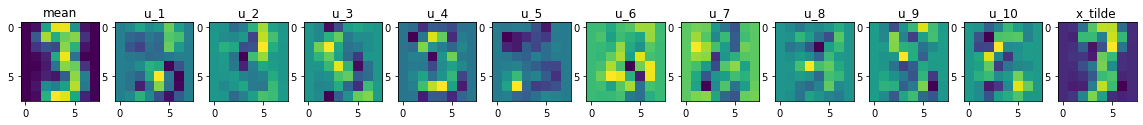

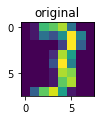

In [12]:
# now let's see what the individual components represent
# first let's perform pca on the data
n_principle_comps = 10
v_p_im, U_p_im, mu_X_im, cvar_X_im, v_im, U_im = do_pca(digit_3_data, n_principle_comps=n_principle_comps)

z_im = transform_low_dim(digit_3_data, U_p_im, mu_X_im)
x_tilde_im = transform_back(z_im, U_p_im, mu_X_im)

c_im = digit_3_data[25]
c_z = z_im[25]
c_x_tilde = x_tilde_im[25]


fig = plt.figure(figsize=(20, 5))
g = plt.GridSpec(1, 2 + n_principle_comps)

# each point in considered_im_z has to be multiplied with corresponding principle component:
principle_comp_images = c_z * U_p_im

# first plot the mean
ax = fig.add_subplot(g[0, 0])
ax.imshow(mu_X_im.reshape(8, 8))#, cmap='binary')
title = 'mean'
ax.set_title(title)

# let's plot the individual component images
for i in range(principle_comp_images.shape[1]):
    c_ax = fig.add_subplot(g[0, i+1])
    c_ax.imshow(principle_comp_images[:, i].reshape(8,8))#, cmap='binary')
    title = 'u_' + str(i+1)
    c_ax.set_title(title)

c_ax = fig.add_subplot(g[0, -1])
# should be the same as considered_im_xtilde
c_ax.imshow((np.sum(principle_comp_images, axis=1) + mu_X_im).reshape(8, 8))#, cmap='binary')
c_ax.set_title('x_tilde ')

plt.figure('original', figsize=(1.35, 1.35))
plt.imshow(digit_3_data[15].reshape(8, 8))#, cmap='binary')
plt.title('original')

In [15]:
c_z

array([-23.34881922, -13.60619721,   3.42935123,   7.8837786 ,
         1.32687664,   4.22197927,  -6.26606042,   8.29971759,
         2.62201432,  -1.24781766])

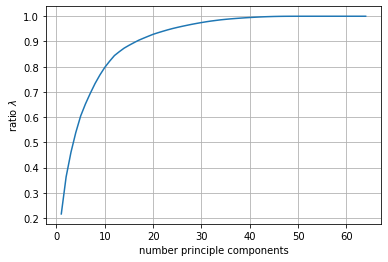

In [9]:
ratios = plot_sum_eig_val_ratio(v_im)